# Python Foundation - Capstone Project

## Exploratory Data Analysis on ‘Dog Training’ YouTube Channel

---

## Problem Statement:

- Thailand is a country with less dog training knowledge in comparison to Europe or even our neighbor Malaysia & Singapore
- One of the main reason is the lack in available educational resources which has stalled developments of both the training skills of trainers and general knowledge of dog owners
- Which allows many ‘poor’, ‘abusive’ and ‘unethical’ dog trainers/breeders to easily take advantage of their customers – from selling ineffective (sometimes counter-productive) courses to breeding and selling unhealthy dogs

## Goal and Target:

- Identify key action points to build and expand my own educational dog training YouTube channel by analyzing insights from dog training channels
- +100 subscribers & +100 views per video

## Social Impact:

- "More educated customers" = "Less unethical trainers/breeders"

## Hypothesis

- Which content relates to the viewers?

- Effects of good title writing?

- What’s the best video duration?

- How many times posts per month?

- Is it better to post on weekdays or weekends?

## Project Pipeline

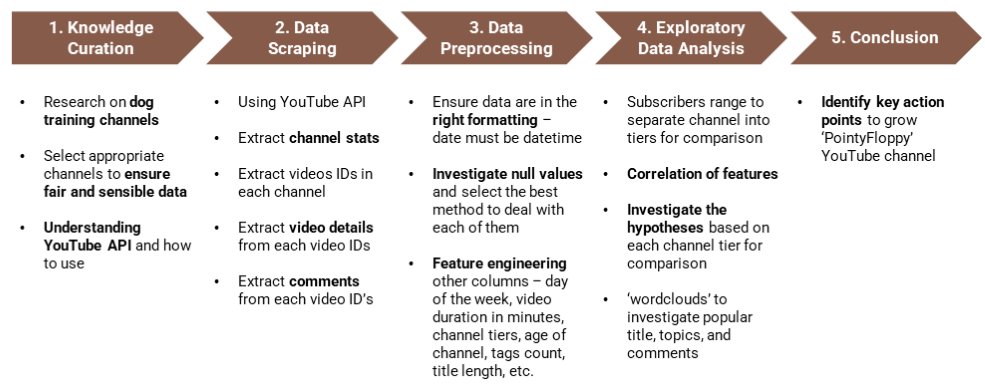

---

## Let's start with importing the required modules, and setting some global parameters

In [ ]:
conda install -c conda-forge pandas-profiling

In [3]:
#data manipulation
import pandas as pd
import numpy as np
from dateutil import parser
import isodate
from pandas_profiling import ProfileReport

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#NLP lib
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from wordcloud import WordCloud

ImportError: cannot import name 'soft_unicode' from 'markupsafe' (C:\Users\smile\anaconda3\lib\site-packages\markupsafe\__init__.py)

In [2]:
#day ordering
day_order = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()

In [3]:
#chosen palette
use_palette = 'magma'

In [4]:
#chosen range and ordering of channel visualization
channel_range = ['high','medium','low']

## Reading and Data Preparation/Feature Engineering for channel data

In [5]:
#read scraped data and set index as col 0
ch_df = pd.read_csv('channel_df.csv', index_col=[0]) 

### Check datatypes

In [6]:
ch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   channel_title       30 non-null     object
 1   channel_desc        25 non-null     object
 2   channel_loc         23 non-null     object
 3   channel_pub_date    30 non-null     object
 4   channel_view        30 non-null     int64 
 5   channel_sub         30 non-null     int64 
 6   channel_video       30 non-null     int64 
 7   channel_playlistId  30 non-null     object
dtypes: int64(3), object(5)
memory usage: 2.1+ KB


- channel_pub_date : should be datetime
- channel_view, channel_sub, channel_video : should be numeric

In [7]:
#change published date to the correct datatype
ch_df['channel_pub_date'] =  ch_df['channel_pub_date'].apply(lambda x: parser.parse(x))

#feature engineer published year
ch_df['channel_pub_year'] = ch_df['channel_pub_date'].apply(lambda x: x.strftime("%Y"))

In [8]:
#selecting columns to convert to numeric
cols_to_numeric = ['channel_view','channel_sub','channel_video','channel_pub_year']

In [9]:
#convert datatypes to numeric - coerce = invalid passing as NaN
ch_df[cols_to_numeric] = ch_df[cols_to_numeric].apply(pd.to_numeric,errors='coerce')

In [10]:
#feature engineering view per video channel
ch_df['view_per_video'] = ch_df['channel_view'] / ch_df['channel_video']

We will separate our channels according to the range of subscribers below:

__High tier (sub > 100,000)__ 

__Medium tier (10,000 < sub <= 100,000)__

__Low tier (sub <= 10,000)__


In [11]:
#sorting channel tier
def channel_tier(subs):
    """
    Sorts channel into tiers based on no. of subscribers

        Parameters
        ----------
        subs : int
            no. of subscribers

        Returns
        -------
        str
            channel tier based on input subs
    """
    if subs > 100000:
        return "high"
    elif subs > 10000:
        return "medium"
    else:
        return "low"

In [12]:
#apply function to sort channel tier
ch_df['channel_tier'] = ch_df['channel_sub'].apply(channel_tier)

#### Check missing data

In [13]:
#filter out channels with missing data (showing percentage of missing data)
ch_df.isnull().mean()[ch_df.isnull().mean() != 0]*100

channel_desc    16.666667
channel_loc     23.333333
dtype: float64

In [14]:
#fill missing description
ch_df['channel_desc'].fillna('No Description',inplace=True)

In [15]:
#fill missing location
ch_df['channel_loc'].fillna('No Location',inplace=True)

#### Final check : confirm no missing data and correct datatypes

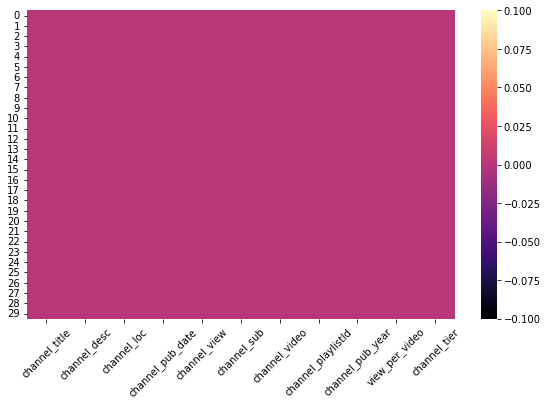

In [16]:
#showing that data is complete and in correct format
plt.figure(figsize=(8,6))
sns.heatmap(ch_df.isnull(),cmap='magma')
plt.tight_layout()
plt.xticks(rotation=45)
;
plt.savefig('./Figures/channel_nonull.jpg')

In [17]:
ch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   channel_title       30 non-null     object                 
 1   channel_desc        30 non-null     object                 
 2   channel_loc         30 non-null     object                 
 3   channel_pub_date    30 non-null     datetime64[ns, tzutc()]
 4   channel_view        30 non-null     int64                  
 5   channel_sub         30 non-null     int64                  
 6   channel_video       30 non-null     int64                  
 7   channel_playlistId  30 non-null     object                 
 8   channel_pub_year    30 non-null     int64                  
 9   view_per_video      30 non-null     float64                
 10  channel_tier        30 non-null     object                 
dtypes: datetime64[ns, tzutc()](1), float64(1), int6

## Data Quality Check for fairness of datasets
We will assess for fairness of datasets with two criteria:

1. no. of channels
2. no. of videos from each channels

We will focus our fairness of datasets on those two criteria as we want a sensible diversity of good practices from each channel, which will generally results in more videos from high tier as they publish more videos.

Check for sensible distribution of channels within each channel tiers

In [18]:
ch_df['channel_tier'].value_counts()

low       11
high      10
medium     9
Name: channel_tier, dtype: int64

There is an acceptable numbers of channel in each tiers, let's check number of videos.

In [19]:
ch_df.groupby('channel_tier').sum()['channel_video']

channel_tier
high      9278
low       2171
medium    2441
Name: channel_video, dtype: int64

There is a significantly higher videos from high tier, let's investigate for potential outlier channel

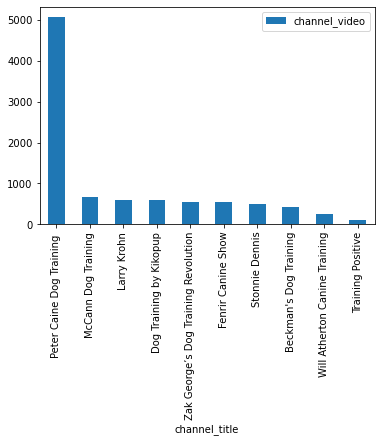

In [20]:
ch_df[ch_df['channel_tier']=='high'].sort_values('channel_video',ascending=False)[['channel_title','channel_video']].plot(kind='bar',x='channel_title')
plt.xticks(rotation=90);

In [21]:
#identify key of outlier
outlier = ch_df[ch_df['channel_tier']=='high'].sort_values('channel_video',ascending=False)['channel_video'].index[0]

In [22]:
ch_df.loc[outlier] #this channel is an outlier, having way more videos than other channels

channel_title         Peter Caine Dog Training 
channel_desc                     No Description
channel_loc                                  US
channel_pub_date      2010-12-24 22:00:49+00:00
channel_view                           36319501
channel_sub                              185000
channel_video                              5058
channel_playlistId     UUGBhmRCsK-hdGyKUP-K02zw
channel_pub_year                           2010
view_per_video                       7180.60518
channel_tier                               high
Name: 22, dtype: object

Investigating this channel shows that he posts everything from daily life to YouTube short videos, this is not what we're looking for. We will proceed to drop this channel from our analysis.

In [23]:
ch_df = ch_df.drop([outlier])

In [24]:
ch_df['channel_tier'].value_counts()

low       11
high       9
medium     9
Name: channel_tier, dtype: int64

Let's check if we've selected channels with acceptable range of subscribers by plotting the distribution of subscribers.

In [25]:
ch_df.groupby('channel_tier').sum()['channel_video']

channel_tier
high      4220
low       2171
medium    2441
Name: channel_video, dtype: int64

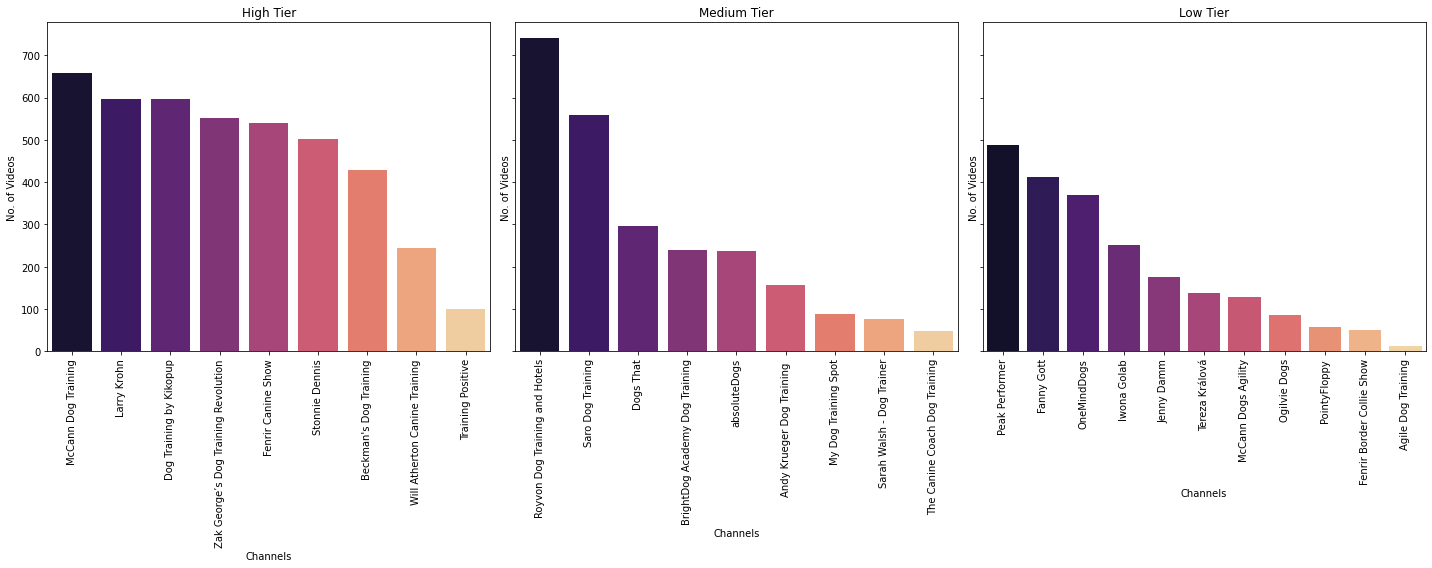

In [26]:
fig, axes = plt.subplots(1, 3,figsize=(20,8),sharey=True)

for i in range(3):
    sns.barplot(ax=axes[i], x='channel_title', y='channel_video',data=ch_df[ch_df['channel_tier']==channel_range[i]].sort_values(by='channel_video',ascending=False),palette=use_palette)
    axes[i].set_xticklabels(ch_df[ch_df['channel_tier']==channel_range[i]].sort_values(by='channel_video',ascending=False)['channel_title'],rotation = 90)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Channels')
    axes[i].set_ylabel('No. of Videos')

plt.tight_layout()
plt.savefig('./Figures/channels_vid.jpg')

The distribution of videos in each channel tier seems sensible, as it shows a gradual increase in no. of videos in each channel. None of the channels dominates the distribution of videos in each tier.

Note that we've selected fair datasets by selecting which channels we will investigate, to match this selection for video datasets we will drop video data from channels that we've dropped as well.

#### Now we have an acceptable dataset to work with. Let's continue to cleaning video datasets!

# Reading and Data Preparation/Feature Engineering for video Data Frame

In [27]:
#read csv
video_df = pd.read_csv('video_df.csv')

#### Check datatypes

In [28]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13895 entries, 0 to 13894
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       13895 non-null  object 
 1   channelTitle   13895 non-null  object 
 2   title          13895 non-null  object 
 3   description    13249 non-null  object 
 4   tags           11142 non-null  object 
 5   publishedAt    13895 non-null  object 
 6   duration       13895 non-null  object 
 7   definition     13895 non-null  object 
 8   caption        13895 non-null  bool   
 9   viewCount      13895 non-null  int64  
 10  likeCount      13876 non-null  float64
 11  favoriteCount  13895 non-null  int64  
 12  commentCount   13407 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 1.3+ MB


- tags needs to be a list of strings
- publishedAt needs to be datetime
- duration needs to be seconds or minutes
- viewCount likeCount favoriteCount commentCount is int from API

In [29]:
#applying datetime string parser
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x))

#feature engineering day / month / year of publishing
video_df['publishedDay'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))
video_df['publishedMonth'] = video_df['publishedAt'].apply(lambda x: x.strftime("%m"))
video_df['publishedYear'] = video_df['publishedAt'].apply(lambda x: x.strftime("%Y"))

In [30]:
#converting datatypes to numeric
num_cols = ['viewCount', 'likeCount','commentCount','publishedMonth','publishedYear']
video_df[num_cols] = video_df[num_cols].apply(pd.to_numeric, errors='coerce')

In [31]:
#applying isodate parser
video_df['duration_sec'] = video_df['duration'].apply(lambda x : isodate.parse_duration(x))

#feature enginineering seconds and minutes (rounded)
video_df['duration_sec'] = video_df['duration_sec'].astype('timedelta64[s]')
video_df['duration_min'] = video_df['duration_sec'].apply(lambda x : round(x/60))

In [32]:
#input list brackets into empty tags columns
video_df['tags'].fillna("[]",inplace=True)

In [33]:
#converting tags to list
video_df['tags_list'] = video_df['tags'].apply(lambda x : x.strip("[]").replace("'","").split(', '))

#feature engineering tags count
video_df['tags_count'] = video_df['tags_list'].apply(lambda x : len(x))

In [34]:
#feature engineering like and comments ratio
video_df['likeRatio'] = video_df['likeCount'] / video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount'] / video_df['viewCount'] * 1000

In [35]:
#feature engineering title length
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))

#### Check for missing data

In [36]:
round(video_df.isnull().mean(),4)[video_df.isnull().mean() != 0]*100

description     4.65
likeCount       0.14
commentCount    3.51
likeRatio       0.17
commentRatio    3.56
dtype: float64

Missing descriptions are just videos without description so we can fill with "No Description"


Missing like and comments are from videos that disabled likes or comments (since they're small, we can drop these)

In [37]:
#fill missing description
video_df['description'].fillna('No Description',inplace=True)

Drop missing data from columns that takes up < 5%

In [38]:
video_df.dropna(subset='likeCount',axis=0,inplace=True)
video_df.dropna(subset='commentCount',axis=0,inplace=True)
video_df.dropna(subset='commentRatio',axis=0,inplace=True)

In [39]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13382 entries, 0 to 13893
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   video_id        13382 non-null  object                 
 1   channelTitle    13382 non-null  object                 
 2   title           13382 non-null  object                 
 3   description     13382 non-null  object                 
 4   tags            13382 non-null  object                 
 5   publishedAt     13382 non-null  datetime64[ns, tzutc()]
 6   duration        13382 non-null  object                 
 7   definition      13382 non-null  object                 
 8   caption         13382 non-null  bool                   
 9   viewCount       13382 non-null  int64                  
 10  likeCount       13382 non-null  float64                
 11  favoriteCount   13382 non-null  int64                  
 12  commentCount    13382 non-null  

From experience, I've noticed that not many people uses favorite, let's investigate whether that is the case for 'dog training' videos.

In [40]:
#check what column 'favorite count is'
video_df['favoriteCount'].value_counts()

0    13382
Name: favoriteCount, dtype: int64

Whole column has no favorite, so we can just drop this column as well

In [41]:
video_df.drop('favoriteCount',axis=1,inplace=True)

Creating a list of channel titles in each channel tier to map with video

In [42]:
low_ch_title = list(ch_df[ch_df['channel_tier']=='low']['channel_title'])
medium_ch_title = list(ch_df[ch_df['channel_tier']=='medium']['channel_title'])
high_ch_title = list(ch_df[ch_df['channel_tier']=='high']['channel_title'])

Create a function to map video to channel tier

In [43]:
def video_tier(channelTitle):
    """
    Sorts channel into tiers based on channel title

        Parameters
        ----------
        channelTitle : str
            name of the channel

        Returns
        -------
        str
            channel tier based on if the title is in a certain channel list
    """
    if channelTitle in high_ch_title:
        return 'high'
    elif channelTitle in medium_ch_title:
        return 'medium'
    else:
        return 'low'

Applying the function to video_df to create channel_tier column

In [44]:
video_df['channel_tier'] = video_df['channelTitle'].apply(video_tier)

From fairness check of dataset, we will drop videos from outlier channel that we have decided not to include.

In [45]:
video_df = video_df[video_df['channelTitle'] != "Peter Caine Dog Training "]

#### Final check : confirm no missing data and correct datatypes

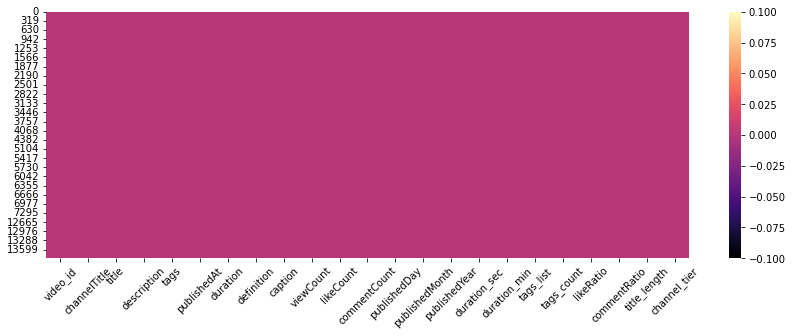

In [46]:
#showing that the data is complete and in correct format
plt.figure(figsize=(12,5))
sns.heatmap(video_df.isnull(),cmap='magma')
plt.tight_layout()
plt.xticks(rotation=45)
;
plt.savefig('./Figures/video_nonull.jpg');

In [47]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8379 entries, 0 to 13893
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   video_id        8379 non-null   object                 
 1   channelTitle    8379 non-null   object                 
 2   title           8379 non-null   object                 
 3   description     8379 non-null   object                 
 4   tags            8379 non-null   object                 
 5   publishedAt     8379 non-null   datetime64[ns, tzutc()]
 6   duration        8379 non-null   object                 
 7   definition      8379 non-null   object                 
 8   caption         8379 non-null   bool                   
 9   viewCount       8379 non-null   int64                  
 10  likeCount       8379 non-null   float64                
 11  commentCount    8379 non-null   float64                
 12  publishedDay    8379 non-null   o

## Now we have a cleaned and fair data for both channel and videos, let's dive in to explore our hypotheses.

## 1. Which content relates to the viewers?
Understanding which content relates to more audience will allow us to identify how we should create our content in order to grow our own audience (i.e. subscribers) and generate more views per video (relationship to investigate). But what kind of content will attract 'dog owners' or 'dog training community'?

To investigate this, we will look at the wordcloud of the titles in each channel tier. Then we will compare which topic comes up more often for each channels and identify the differences to see how we can improve.

In [48]:
#setting stop words to english
stop_words = set(stopwords.words('english'))

In [49]:
#creating empty dataframe to store titles
low_title = pd.DataFrame()
medium_title = pd.DataFrame()
high_title = pd.DataFrame()

#remove stopwords from titles and store to column 'title_no_stopwords'
low_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='low']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
medium_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='medium']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
high_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='high']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [50]:
#convert list of list to one list of title words
low_title_words = [a for b in low_title['title_no_stopwords'].tolist() for a in b] 
medium_title_words = [a for b in medium_title['title_no_stopwords'].tolist() for a in b] 
high_title_words = [a for b in high_title['title_no_stopwords'].tolist() for a in b]

In [51]:
#join list to one giant string of title words
low_title_words_str = ' '.join(low_title_words)
medium_title_words_str = ' '.join(medium_title_words)
high_title_words_str = ' '.join(high_title_words)

In [52]:
#join to one list to create subplot
title_str = [high_title_words_str,medium_title_words_str,low_title_words_str]

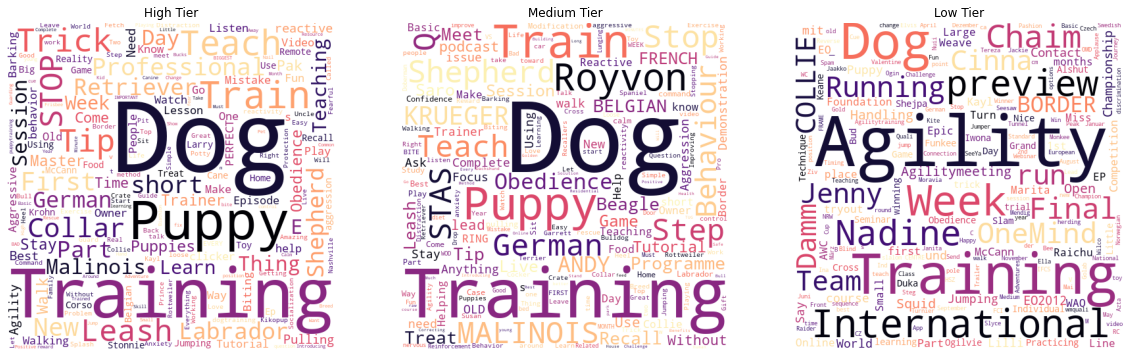

In [53]:
#plot a subplot of wordclouds
fig = plt.figure(figsize=(20,20))

for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plt.imshow(WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(title_str[i]))
    plt.axis('off');
    plt.title(f'{channel_range[i].capitalize()} Tier')

plt.savefig('./Figures/title_wordcloud.jpg')

We can see the following contents chosen by each channel tier:

__High Tier__
- Has chosen a more generic and broad contents which relates to more viewers, allowing the channels to grow their subscribers
- e.g. Puppy, Collar, Trick, Teach, Train, Stop, Leash, Stay

__Medium Tier__
- Has taken a similar approach to 'High Tier' as we can see some basic commands contents e.g. Recall, Obedience

__Low Tier__
- Focuses on specific videos that only a specific niche group of people will relate to e.g. Agility, International (competition), Week (Vlog), Jenny/Nadine (Trainer name), Border Collie (Breed)

There is a more diversity in contents within high tier channels in comparison to low tier channels. This allows high tier channels to reach more viewers and gain more subscribers. Let's investigate whether more subscribers will generate more views.

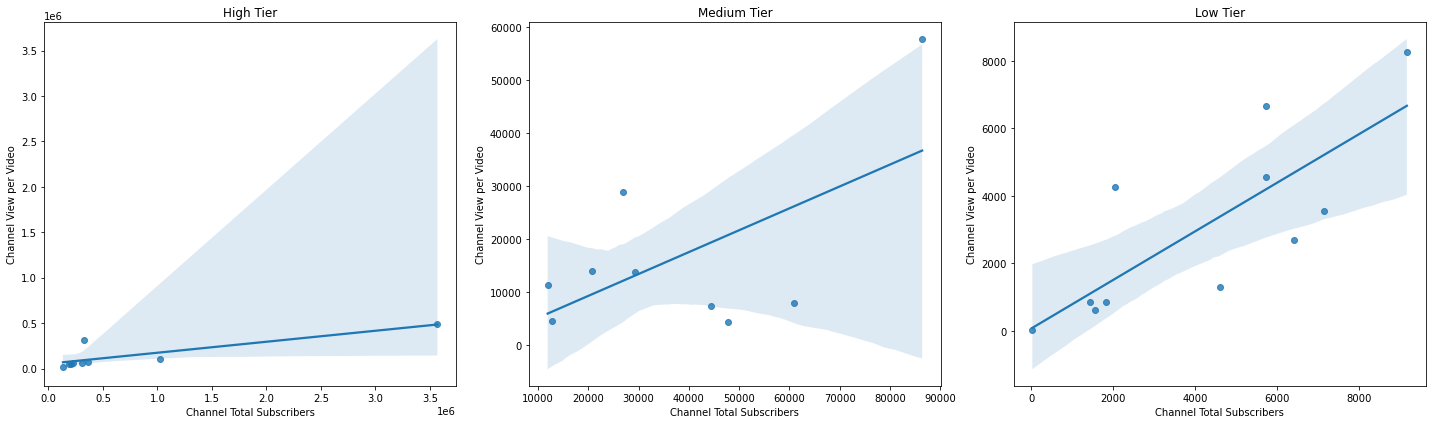

In [54]:
#excluding the top two outliers - we will investigate the channel sub vs channel views
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.regplot(ax=axes[i], x='channel_sub', y='view_per_video',data=ch_df[ch_df['channel_tier']==channel_range[i]])
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Channel Total Subscribers')
    axes[i].set_ylabel('Channel View per Video')

plt.tight_layout()
plt.savefig('./Figures/channel_sub_vs_view.jpg')

We can see that as the number of subscribers increases, the trend suggests an increment in views per videos as well. So there is a correlation between the number of subscribers and the number of views per video. Therefore, the decision to diversify content is justified.

__Strategy 1: Contents that are more generic will relate to more audience, potentially increasing the number of subscribers and ultimately increases the number of views per video.__

## 2. What's the best video duration?
Creating a video with appropriate duration could be beneficial as video duration influences whether or not viewers will click on a video. For example, with basketball highlights, people tends to watch videos of around 10-15 minutes rather than videos of 2 minutes as they're too short to contain anything or 30 minutes as they are too long to digest. We must identify the sweet spot of video duration that will please our audience.

To investigate this, we will look at the distribution of video duration between each channel tiers. Then we will investigate the relationship between video duration and view counts / comment counts (to check if there is a correlation between video duration and video engagement).

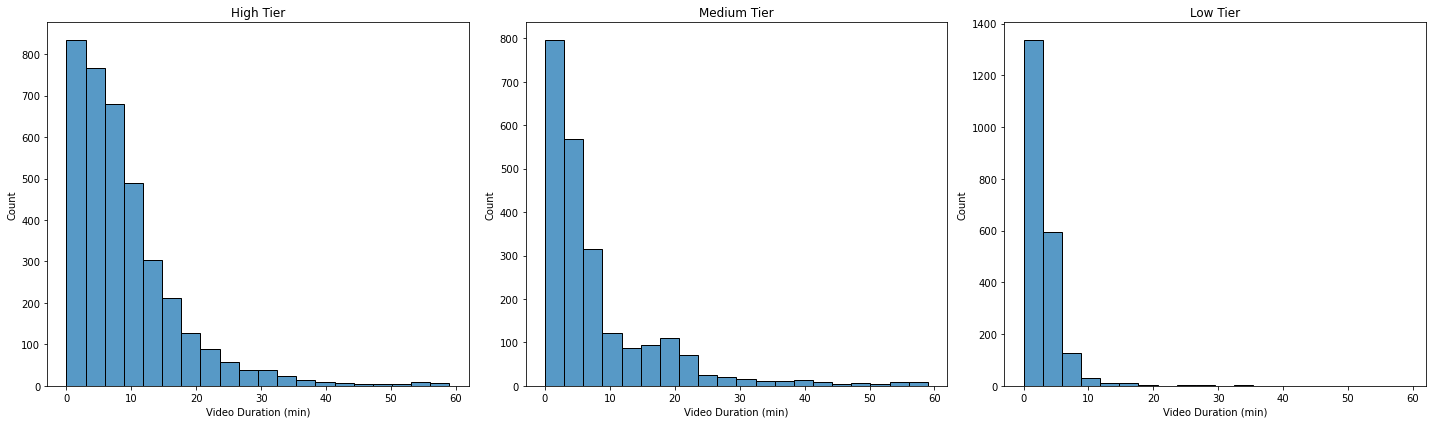

In [55]:
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharex=True)

for i in range(3):
    sns.histplot(ax=axes[i],x='duration_min', bins=20, data=video_df[(video_df['channel_tier']==channel_range[i]) & (video_df['duration_min'] < 60)],palette=use_palette)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Video Duration (min)')

plt.tight_layout()
plt.savefig('./Figures/duration_distribution.jpg')

#limited to 60 min to exclude livestream

Here we can see that most of the distribution of video duration is right skewed, meaning more videos are leaning towards the shorter duration side. With the degree of skewness reducing as we move up the channel tier, we notice that higher tier channels generally creates longer videos.

To investigate further, we need to look a scatterplot of the duration and view count.

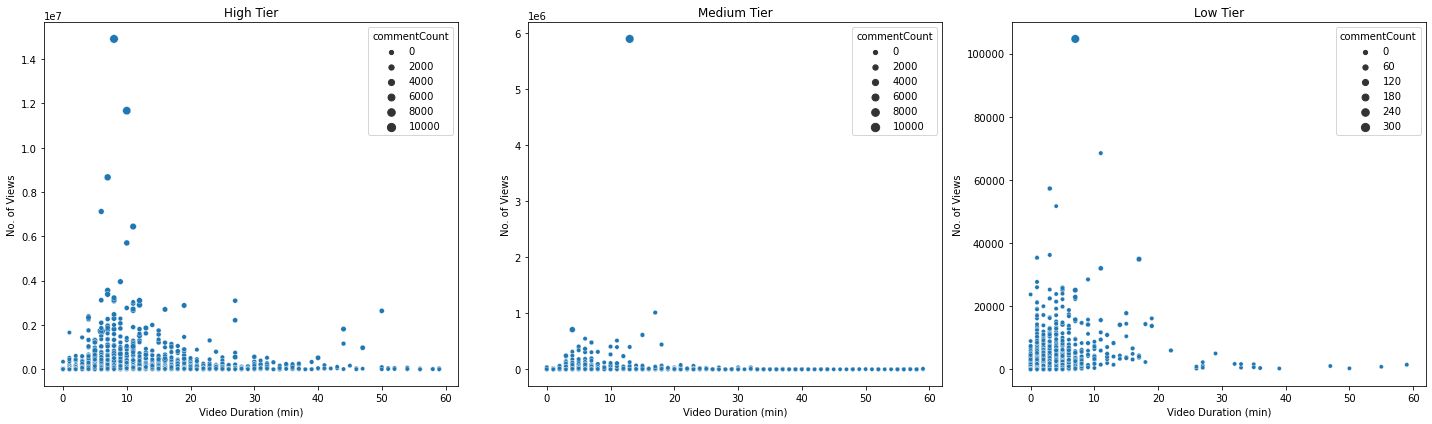

In [56]:
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharex=True)

for i in range(3):
    sns.scatterplot(ax=axes[i],x='duration_min',y='viewCount',data=video_df[(video_df['channel_tier']==channel_range[i]) & (video_df['duration_min'] < 60)],size='commentCount')
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Video Duration (min)')
    axes[i].set_ylabel('No. of Views')

plt.tight_layout()
plt.savefig('./Figures/duration_view_scatter.jpg')

#limited to 60 min to exclude livestream

Looking at 'High Tier' videos we can see that the peak views are around 10 minute mark and even if we ignore those peak view videos that went viral, we can see that the there is a trend that video durations around 10 minute mark generally gets more views. Similar pattern exists with 'Medium Tier' videos. However, with 'Low Tier' the trend is not as clear, but the peak views still lies around 10 minute mark. We can generally aim to create video of around 10 minutes from this finding.

__Strategy 2: Video duration should be kept around 10 minutes, as long videos tend to be too intimidating for people to watch, and short videos could easily be disregarded as not enough content to worth watching__

## 3. Effects of good title writing?
Title is one of the first things that our audience will notice and is the early source of information that allows the audience to quickly understand or guess what the video might be about. Knowing the content of the video allows our audience to choose whether or not that particular video is worth watching. So in addition to choosing the right content and video duration, we must also learn how to write good titles.

To investigate this, we will look at videos with top views from the top channels to identify key writing points and patterns. We will not look at low and medium tier, because we've established that low tier writes title in the form of video tracking (i.e. Week x, Agility Training EP x), and because we just want to identify the good practices from successful titles.

In [57]:
#High Tier - select top 10 videos sort by views from top 2 channels

kikopup = pd.DataFrame(video_df[video_df['channelTitle'] == "Dog Training by Kikopup"])
zak = pd.DataFrame(video_df[video_df['channelTitle'] == "Zak George’s Dog Training Revolution"])
kikopup_top10 = kikopup.sort_values(by='viewCount',ascending=False).head(10)
zak_top10 = zak.sort_values(by='viewCount',ascending=False).head(10)

In [58]:
#set up empty dataframe
kiko_title = pd.DataFrame()
zak_title = pd.DataFrame()

#split title words without removing stopwords
kiko_title['title'] = kikopup_top10['title'].apply(lambda x : [item for item in x.split()])
zak_title['title'] = zak_top10['title'].apply(lambda x : [item for item in x.split()])

In [59]:
#combine to one list
kiko_title_words = [a for b in kiko_title['title'].tolist() for a in b] 
zak_title_words = [a for b in zak_title['title'].tolist() for a in b]

In [60]:
#join to string
kiko_title_words_str = ' '.join(kiko_title_words)
zak_title_words = ' '.join(zak_title_words)

In [61]:
#join to one list to create subplot
top_title_str = [kiko_title_words_str,zak_title_words]

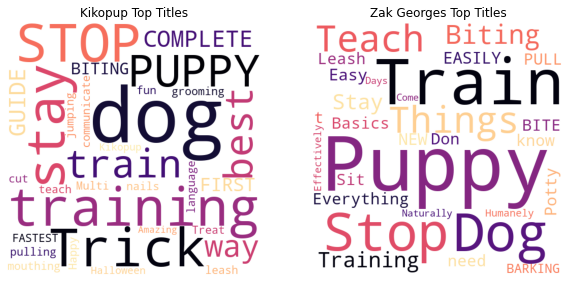

In [62]:
#plot a subplot of wordclouds
fig = plt.figure(figsize=(10,10))
title_range = ['Kikopup Top Titles','Zak Georges Top Titles']

for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    plt.imshow(WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_title_str[i]))
    plt.axis('off');
    plt.title(f'{title_range[i]}')

plt.savefig('./Figures/top_title_wordcloud.jpg')

Comparing the wordclouds from the two channels, we can see that they're very easy to understand. It's almost as if we can pick a few words and it will mean something, for example "Train Dog Stop Biting" will make sense as a title. Therefore a good practice is to make sure our audience know what they'll get from watching our YouTube videos.

Below are example titles from 20 most viewed videos from Kikopup and Zak George.

In [63]:
pd.set_option('display.max_colwidth', None) #change column width limit to display the full title
kikopup_top10[['title','viewCount']]

,title,viewCount
13045,COMPLETE GUIDE to PUPPY TRAINING - What to train FIRST,2764023
13348,STOP your puppy BITING mouthing,2286346
13423,Train your dog to STOP pulling on leash,1757110
13184,Multi Dog Tricks,1658539
13211,The best way to cut your dog's nails - dog training grooming,1438576
13382,How to communicate with a dog in his own language,1033005
13339,"The BEST and FASTEST way to teach STAY - stay training, stay fun!",903303
13364,STOP jumping up!,655533
13390,Trick or Treat? - Happy Halloween from Kikopup,606756
13393,Amazing Dog Tricks,595053


In [64]:
zak_top10[['title','viewCount']]

,title,viewCount
1275,3 Easy Things to Teach your NEW PUPPY!,14913945
1285,How to Potty Train your Puppy EASILY! Everything you need to know!,11673532
1234,How to Train your Puppy to Stop Biting,8665432
1385,Dog Training 101: How to Train ANY DOG the Basics,7122664
1332,How to Train a Puppy NOT to BITE,6443640
1316,How to Stop Puppy Biting and Don’t Do These 5 Things When Training Your Puppy,5703474
1362,How to Train Your Dog to NOT PULL on the Leash!,3955360
1212,How to Teach your Puppy to Sit and Stay,3561147
1364,"How to TEACH ANY DOG to STOP BARKING Humanely, Effectively, and Naturally!",3382797
1329,"How to Train Your Puppy 8 Things in 7 Days! (STOP Puppy Biting, Come, Stay... )",3228375


__Strategy 3: Writing informative title helps audience grasp key concepts of what this video will provide them, and quickly decide whether or not they will want to watch the video. Combining this with correct video duration and content choice will make our video more likely to be watched__

## 4. How many publishing per month?
Maintaining an audience is as important as growing an audience. In fact if you ask channel owners in any channel category, we will get the same tips of 'being consistent'. Consistency allows our audience to know what to expect from our channel, this creates a constant connection between content creator and audience. But how many videos per month should be published for a 'dog training' channel?

To investigate this, we will compare the number of videos posted by each channel tier in each month on average compared to the no. of views generated in each month on average. Note that we will focus on 2021 in general.

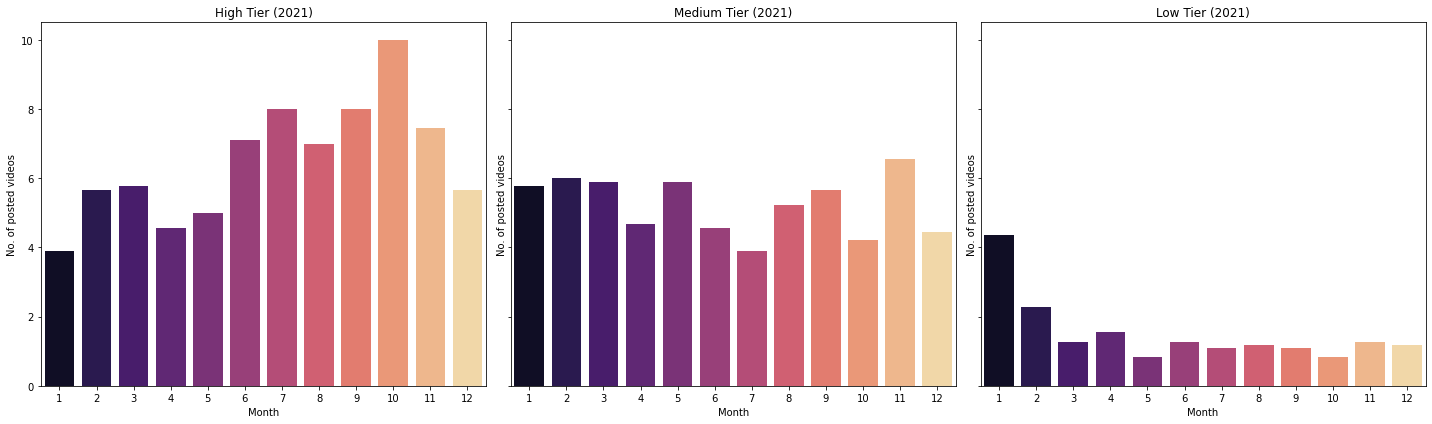

In [65]:
#check average posted videos per month
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharey=True)

for i in range(3):
    posted_video = pd.DataFrame(video_df[(video_df['channel_tier']==channel_range[i]) & (video_df['publishedYear'] == 2021)].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']==channel_range[i]].shape[0])
    sns.barplot(ax=axes[i],x=posted_video.index,y='video_id',data=posted_video, palette=use_palette)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier (2021)')
    axes[i].set_ylabel('No. of posted videos')
    axes[i].set_xlabel('Month')

plt.tight_layout()
plt.savefig('./Figures/post_per_month.jpg')

We can see a clear difference in average number of videos posted per month per channel when we compare the three plots together. 'Low Tier' channels posts only about 1-2 videos per month (i.e. once every 2-4 weeks). Meanwhile, 'High Tier' and 'Medium Tier', posts at least 1 videos per week.

Therefore, to maintain an audience, we should follow the practice of high and medium tier youtube channel. But without a big production team, we should aim for a sensible number of approximately 1 video per week.

__Strategy 4: Publish about 1 video per week as this will help maintain an audience that we've built.__

## 5. Should we post on weekdays or weekends?
Intuitively, we might think that posting on a weekend will get more people, but we need a data-based evidence to back up our hypothesis.

To investigate this, we will compare the number of videos posted by each channel on each day and compare it with the number of views for those videos.

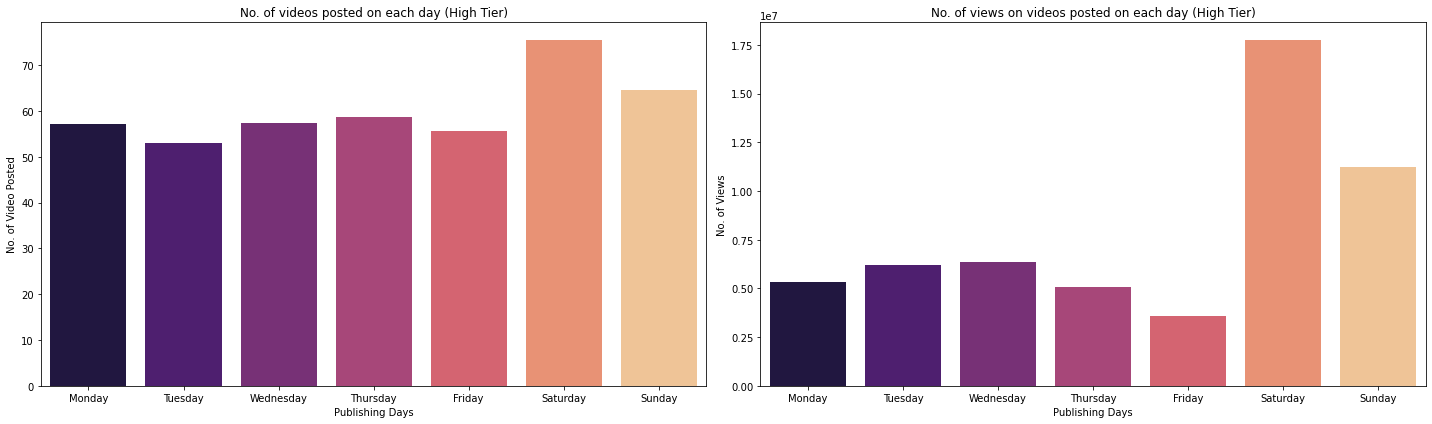

In [66]:
#Compare no. of videos on each day with no. of views on videos on each day
fig, axes = plt.subplots(1, 2,figsize=(20,6))

posted_video_day = pd.DataFrame(video_df[video_df['channel_tier']=='high'].groupby('publishedDay').count()['video_id']/ch_df[ch_df['channel_tier']=='high']['channel_title'].count())
sns.barplot(ax=axes[0], x=posted_video_day.index, y='video_id', data=posted_video_day, order=day_order,palette=use_palette)
axes[0].set_title('No. of videos posted on each day (High Tier)')
axes[0].set_ylabel('No. of Video Posted')
axes[0].set_xlabel('Publishing Days')

view_day = pd.DataFrame(video_df[video_df['channel_tier']=='high'].groupby('publishedDay').sum()['viewCount']/ch_df[ch_df['channel_tier']=='high']['channel_title'].count())
sns.barplot(ax=axes[1], x=view_day.index, y='viewCount', data=view_day,order=day_order,palette=use_palette,errwidth=0)
axes[1].set_title('No. of views on videos posted on each day (High Tier)')
axes[1].set_ylabel('No. of Views')
axes[1].set_xlabel('Publishing Days')

plt.tight_layout()
plt.savefig('./Figures/day_post.jpg')

Focusing on 'High Tier' we can see that there is slightly more no. of videos posted per day on weekends than on weekdays. Notice that the slightly higher number of video posted on weekends results in much higher views on weekends (relatively). This suggests a pattern that posting on weekends tends to generate more views than on weekdays. 

__Strategy 5: It is better to post on weekends than on weekdays, so I must schedule my publishing day to weekends__

## Therefore, to summarise my findings:

__Here are the 5 strategies that we can follow, to grow our 'dog training' youtube channel:__

1. __Contents that are more generic__ will relate to more audience, potentially increasing the number of subscribers and ultimately increases the number of views per videos.
2. __Video duration should be kept around 10 minutes__, as long videos tend to be too intimidating for people to watch, and short videos could easily be disregarded as not enough content to even worth watching.
3. __Writing informative title helps our audience grasp key concepts__ of what this video will provide them, and quickly decide whether or not they will want to watch our video.
4. __Publish about 1 video per week__ as this will help maintain our audience base.
5. __It's better to post on weekends__ than on weekdays, so I must schedule publishing day to be on weekends.

# Let's create a better world for dogs!

---

# Future potential areas to investigate

- __Thumbnail__ is another interesting area to investigate, if there is a way to identify custom uploaded thumbnail vs selected frame of uploaded video then that's worth exploring
- Explore the __timeline__ of each channel to identify how each grow their own channel (potentially identifying spikes in subscribers and viewers)
- Compare __contents__ in each video vs performance and comment feedback (categorize each video into specific topics from title keywords)